In [66]:
# -------------------------
# 1. Imports
# -------------------------
import requests
import pandas as pd
import geopandas as gpd
import json
import psycopg2
import osmnx as ox
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np
from IPython.display import IFrame, display
import webbrowser   
import folium
from pathlib import Path



In [67]:
# # -------------------------
# # 2. Database connection
# # -------------------------
# conn = psycopg2.connect(
#     host="localhost",
#     port="5432",


    
#     user="postgres",
#     password="Kalyani1" ,
#     database="postgis_36_sample"
# )

# cur = conn.cursor()

In [68]:
# -------------------------
# 2. Database connection (interactive)
# -------------------------
import getpass
import psycopg2

print("Enter PostgreSQL connection details:")

db_host = input("Host (default: localhost): ").strip() or "localhost"
db_port = input("Port (default: 5432): ").strip() or "5432"
db_name = input("Database name: ").strip()
db_user = input("Username: ").strip()
db_password = getpass.getpass("Password: ")

# Save into a config dictionary (optional but clean)
db_config = {
    "host": db_host,
    "port": db_port,
    "database": db_name,
    "user": db_user,
    "password": db_password
}

# Try connecting
try:
    conn = psycopg2.connect(**db_config)
    cur = conn.cursor()
    print("\n✅ Database connection successful!")

except Exception as e:
    print("\n❌ Failed to connect to database:")
    print(e)
    raise


Enter PostgreSQL connection details:

✅ Database connection successful!


In [69]:
# -------------------------
# 3. Functions for WFS download
# -------------------------
def download_wfs_geojson(url, layer_name, crs="EPSG:28992"):
    """
    Fetches a WFS layer and returns it as a GeoDataFrame.
    """
    params = {
        "service": "WFS",
        "version": "1.1.0",
        "request": "GetFeature",
        "typeName": layer_name,
        "outputFormat": "application/json",
        "srsName": crs
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return gpd.read_file(r.text)
 

In [70]:
# -------------------------
# 4. Download Administrative boundaries
# -------------------------
print("Downloading administrative boundaries (municipalities)...")
muni = download_wfs_geojson(
    "https://service.pdok.nl/kadaster/bestuurlijkegebieden/wfs/v1_0?",
    "bg:Gemeentegebied"
)
muni.to_file("municipal_boundaries.geojson", driver="GeoJSON")
 
# -------------------------
# 5. Download Population data
# -------------------------
print("Downloading population data (CBS LAU)...")
pop = download_wfs_geojson(
    "https://service.pdok.nl/cbs/pd/wfs/v1_0?",
    "pd:pd-nl-lau-2018"
)
pop.to_file("popdensitylau.geojson", driver="GeoJSON")

In [71]:
import os

# -------------------------
# 4. Download Administrative boundaries (robust)
# -------------------------
print("Downloading administrative boundaries (municipalities)...")

muni_path = "municipal_boundaries.geojson"

if os.path.exists(muni_path):
    print("Loading cached municipal boundaries...")
    muni = gpd.read_file(muni_path)
else:
    muni = download_wfs_geojson(
        "https://service.pdok.nl/kadaster/bestuurlijkegebieden/wfs/v1_0?",
        "bg:Gemeentegebied",
        crs="EPSG:4326"  # safer for WFS
    )
    if muni.empty:
        raise RuntimeError("Municipality WFS returned 0 features — service may be down or layer name changed.")
    muni = muni.to_crs(epsg=28992)
    muni.to_file(muni_path, driver="GeoJSON")

print(f"Municipalities downloaded: {len(muni)}")
print("CRS:", muni.crs)

# -------------------------
# 5. Download Population data (robust)
# -------------------------
print("\nDownloading population data (CBS LAU)...")

pop_path = "popdensitylau.geojson"

if os.path.exists(pop_path):
    print("Loading cached population data...")
    pop = gpd.read_file(pop_path)
else:
    pop = download_wfs_geojson(
        "https://service.pdok.nl/cbs/pd/wfs/v1_0?",
        "pd:pd-nl-lau-2018",
        crs="EPSG:4326"
    )
    if pop.empty:
        raise RuntimeError("Population WFS returned 0 features — layer may be deprecated or temporarily unavailable.")
    pop = pop.to_crs(epsg=28992)
    pop.to_file(pop_path, driver="GeoJSON")

print(f"Population polygons downloaded: {len(pop)}")
print("CRS:", pop.crs)

# -------------------------
# Quick sanity checks
# -------------------------
print("\nSanity check:")
print("Municipality columns:", list(muni.columns))
print("Population columns:", list(pop.columns))

# Check geometry validity
print("Invalid municipality geometries:", (~muni.is_valid).sum())
print("Invalid population geometries:", (~pop.is_valid).sum())


Loading cached municipal boundaries...
Municipalities downloaded: 342
CRS: EPSG:28992

Loading cached population data...
Population polygons downloaded: 380
CRS: EPSG:28992

Sanity check:
Municipality columns: ['id', 'identificatie', 'naam', 'code', 'ligtInProvincieCode', 'ligtInProvincieNaam', 'geometry']
Population columns: ['id', 'gml_id', 'localId', 'namespace', 'versionId', 'identifier', 'identifierScheme', 'language', 'nameStatus', 'sourceOfName', 'pronunciation', 'text', 'script', 'beginLifespanVersion', 'endLifespanVersion', 'timePosition', 'referencePeriod_end', 'leastDetailedScale', 'areaValue', 'areaValue_uom', 'landAreaValue', 'livableAreaValue', 'tesselation_localId', 'tesselation_namespace', 'PD_NL_LAU_T_STAT', 'PD_NL_LAU_T_MEASURE', 'PD_NL_LAU_PERIOD_OF_REFERENCE', 'PD_NL_LAU_T_OBS_VALUE', 'PD_NL_LAU_D_STAT', 'PD_NL_LAU_D_MEASURE', 'PD_NL_LAU_D_OBS_VALUE', 'PD_NL_LAU_M_STAT', 'PD_NL_LAU_M_MEASURE', 'PD_NL_LAU_M_OBS_VALUE', 'PD_NL_LAU_F_STAT', 'PD_NL_LAU_F_MEASURE', 'PD_N

In [72]:
# -------------------------
# 6. Create tables in Postgres
# -------------------------
cur.execute("""
CREATE TABLE IF NOT EXISTS public.municipalboundaries (
    id SERIAL PRIMARY KEY,
    identificatie text,
    naam text,
    code text,
            
            
    ligtinprovinciecode text,
    ligtinprovincienaam text,
    geom geometry(Geometry, 28992)
)
""")
cur.execute("""
CREATE TABLE IF NOT EXISTS public.popdensitylau (
    id SERIAL PRIMARY KEY,
    gml_id text,
    localid text,
    namespace text,
    versionid text,
    identifier text,
    identifierscheme text,
    language text,
    namestatus text,
    sourceofname text,
    pronunciation text,
    text text,
    script text,
    beginlifespanversion text,
    endlifespanversion text,
    timeposition text,
    referenceperiod_end text,
    leastdetailedscale integer,
    areavalue double precision,
    areavalue_uom text,
    landareavalue double precision,
    livableareavalue double precision,
    tesselation_localid text,
    tesselation_namespace text,
    pd_nl_lau_t_stat text,
    pd_nl_lau_t_measure text,
    pd_nl_lau_period_of_reference text,
    pd_nl_lau_t_obs_value integer,
    pd_nl_lau_d_stat text,
    pd_nl_lau_d_measure text,
    pd_nl_lau_d_obs_value double precision,
    pd_nl_lau_m_stat text,
    pd_nl_lau_m_measure text,
    pd_nl_lau_m_obs_value integer,
    pd_nl_lau_f_stat text,
    pd_nl_lau_f_measure text,
    pd_nl_lau_f_obs_value integer,
    geom geometry(Geometry, 28992)
)
""")
conn.commit()

In [73]:
import geopandas as gpd
import osmnx as ox

# -------------------------
# Ask user for province
# -------------------------
province_name = input("Enter province name (default: Zuid-Holland): ").strip()
if province_name == "":
    province_name = "Zuid-Holland"
print(f"Province selected: {province_name}")

# -------------------------
# Prepare province geometry
# -------------------------
province_munis = muni.to_crs(epsg=28992)
province_munis = province_munis[
    province_munis["ligtInProvincieNaam"].str.lower() == province_name.lower()
].copy()

if province_munis.empty:
    raise ValueError(f"No municipalities found for province '{province_name}'")

# Dissolve municipalities into one polygon
province_geom_m = province_munis.dissolve().geometry.iloc[0].buffer(0)

# IMPORTANT: simplify in meters (reduces Overpass load)
province_geom_m = province_geom_m.simplify(1000)  # 1 km tolerance

# Convert to WGS84 for OSM query
province_geom = gpd.GeoSeries([province_geom_m], crs="EPSG:28992").to_crs(epsg=4326).iloc[0]

# -------------------------
# Fetch healthcare facilities from OSM
# -------------------------
ox.settings.use_cache = True
ox.settings.log_console = False

health_tags = {"amenity": ["hospital", "clinic", "doctors"]}

print("Querying OSM for healthcare facilities... (this may take ~30 seconds)")

healthcare_gdf = ox.features_from_polygon(province_geom, health_tags)

# Reproject to meters for analysis
healthcare_gdf = healthcare_gdf.to_crs(epsg=28992)

print(f"Number of healthcare facilities fetched in {province_name}: {len(healthcare_gdf)}")

# Save output
healthcare_gdf.to_file("healthcare_filtered.geojson", driver="GeoJSON")
print("Saved to healthcare_filtered.geojson")


Province selected: Overijssel
Querying OSM for healthcare facilities... (this may take ~30 seconds)
Number of healthcare facilities fetched in Overijssel: 167
Saved to healthcare_filtered.geojson


In [74]:
# -------------------------
# 7. Automatically derive extent and create fishnet (1 km)
# -------------------------
import numpy as np
from shapely.geometry import box

print("Creating 1 km fishnet over municipalities...")

# Ensure CRS exists
if muni.crs is None:
    raise ValueError("Municipal boundaries have no CRS defined.")

# Reproject to metric CRS (RD New)
muni_m = muni.to_crs(epsg=28992)

# Get total bounds
minx, miny, maxx, maxy = muni_m.total_bounds

# Define grid resolution
cell_size = 1000  # meters (1 km)

# Generate grid cells
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)

grid_cells = []
for x in xs:
    for y in ys:
        grid_cells.append(box(x, y, x + cell_size, y + cell_size))

fishnet = gpd.GeoDataFrame(geometry=grid_cells, crs=muni_m.crs)

# Clip grid to municipality boundaries
fishnet = gpd.overlay(fishnet, muni_m, how="intersection")

# Add unique ID
fishnet["grid_id"] = range(len(fishnet))

# Save fishnet
fishnet.to_file("municipality_fishnet_1km.geojson", driver="GeoJSON")

print(f"Fishnet created with {len(fishnet)} cells.")


Creating 1 km fishnet over municipalities...
Fishnet created with 52808 cells.


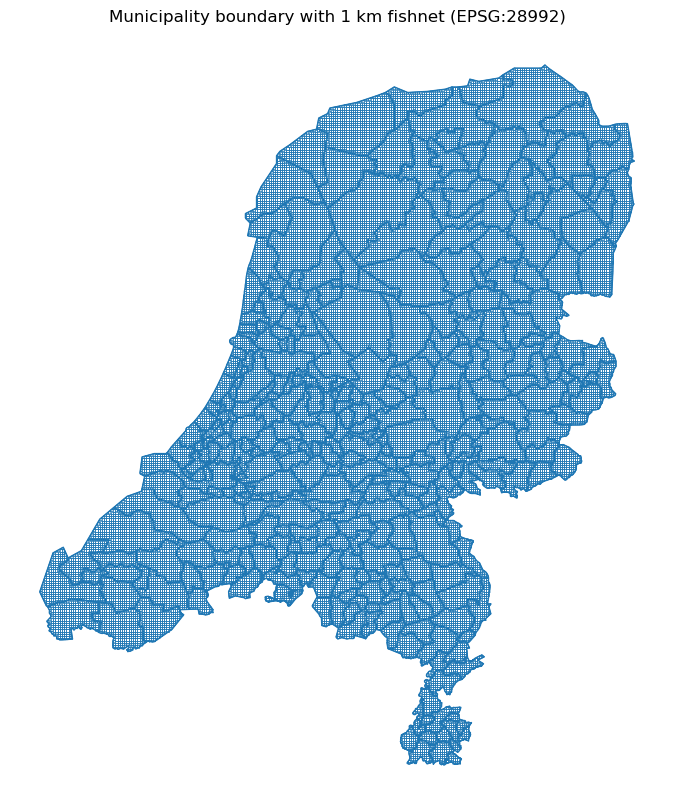

In [75]:
# ------------------------- #
# Load, reproject, visualize in EPSG:28992
# ------------------------- #
import geopandas as gpd
import matplotlib.pyplot as plt

# Load files
muni = gpd.read_file("municipal_boundaries.geojson")
fishnet = gpd.read_file("municipality_fishnet_1km.geojson")

# Force both to EPSG:28992
muni = muni.to_crs(epsg=28992)
fishnet = fishnet.to_crs(epsg=28992)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
muni.boundary.plot(ax=ax, linewidth=1)
fishnet.boundary.plot(ax=ax, linewidth=0.5)

ax.set_title("Municipality boundary with 1 km fishnet (EPSG:28992)")
ax.axis("off")
plt.show()


In [76]:
# ------------------------- #
#Compute centroids in EPSG:28992
# ------------------------- #

# Compute centroids
fishnet["centroid"] = fishnet.geometry.centroid

# Create centroid GeoDataFrame with only point geometry
centroids = fishnet[["grid_id", "centroid"]].copy()
centroids = centroids.set_geometry("centroid")
centroids = centroids.rename_geometry("geometry")

# Save centroids
centroids.to_file("fishnet_centroids_1km_epsg28992.geojson", driver="GeoJSON")

print("Centroids calculated and saved in EPSG:28992.")



Centroids calculated and saved in EPSG:28992.


In [77]:
# ------------------------- #
#1. Retrieve the number of healthcare facilities per province in the Netherlands.

# ------------------------- #
# Prepare province municipalities
# ------------------------- #
# province_name = "Zuid-Holland"

province_munis = muni.to_crs(epsg=28992)
province_munis = province_munis[
    province_munis["ligtInProvincieNaam"].str.lower() == province_name.lower()
].copy()

if province_munis.empty:
    raise ValueError(f"No municipalities found for province '{province_name}'")

# Dissolve province geometry
province_geom_m = province_munis.dissolve().geometry.iloc[0].buffer(0)
province_geom_m = province_geom_m.simplify(1000)

province_geom = gpd.GeoSeries([province_geom_m], crs="EPSG:28992").to_crs(epsg=4326).iloc[0]

# ------------------------- #
# Fetch healthcare facilities
# ------------------------- #
ox.settings.use_cache = True
ox.settings.log_console = False

health_tags = {"amenity": ["hospital", "clinic", "doctors"]}

print("Fetching healthcare facilities from OSM...")
healthcare_zuid_holland = ox.features_from_polygon(province_geom, health_tags)
healthcare_zuid_holland = healthcare_zuid_holland.to_crs(epsg=28992)

print(f"Total healthcare facilities in {province_name}: {len(healthcare_zuid_holland)}")

# ------------------------- #
# Assign facilities to municipalities
# ------------------------- #
hc_muni = gpd.sjoin(
    healthcare_zuid_holland,
    province_munis[["naam", "geometry"]],
    how="left",
    predicate="within"
)

# ------------------------- #
# Count facilities per municipality
# ------------------------- #
facility_count = (
    hc_muni.groupby("naam")
    .size()
    .reset_index(name="facility_count")
)

# ------------------------- #
# Print top 5
# ------------------------- #
top5 = facility_count.sort_values("facility_count", ascending=False).head(5)
print("\nQ 1. Retrieve the number of healthcare facilities per municipality in the province.")

print("\nTop 5 municipalities by number of healthcare facilities:")
for _, row in top5.iterrows():
    print(f"- {row['naam']}: {row['facility_count']} facilities")

# ------------------------- #
# Save outputs
# ------------------------- #
facility_count.to_csv("facility_count_by_municipality.csv", index=False)

facility_count_gdf = province_munis.merge(facility_count, on="naam", how="left")
facility_count_gdf["facility_count"] = facility_count_gdf["facility_count"].fillna(0)

facility_count_gdf.to_file("facility_count_by_municipality.geojson", driver="GeoJSON")
healthcare_zuid_holland.to_file("healthcare_zuid_holland.geojson", driver="GeoJSON")

print("\nSaved files:")
print("- healthcare_layer.geojson")
print("- facility_count_by_municipality.csv")
print("- facility_count_by_municipality.geojson")


Fetching healthcare facilities from OSM...
Total healthcare facilities in Overijssel: 167

Q 1. Retrieve the number of healthcare facilities per municipality in the province.

Top 5 municipalities by number of healthcare facilities:
- Zwolle: 33 facilities
- Enschede: 25 facilities
- Hengelo (O): 18 facilities
- Hardenberg: 13 facilities
- Deventer: 13 facilities

Saved files:
- healthcare_layer.geojson
- facility_count_by_municipality.csv
- facility_count_by_municipality.geojson


In [78]:
# ------------------------- #
# 2. Calculate underserved area (>5 km to nearest healthcare) per municipality
# -------------------------
# Ensure CRS consistency
# -------------------------
fishnet = fishnet.to_crs(epsg=28992)
healthcare_zuid_holland = healthcare_zuid_holland.to_crs(epsg=28992)
province_munis = province_munis.to_crs(epsg=28992)

# -------------------------
# Build KD-tree from healthcare locations
# -------------------------
hc_points = np.array([
    (geom.x, geom.y)
    for geom in healthcare_zuid_holland.geometry
    if geom.geom_type == "Point"
])

hc_tree = cKDTree(hc_points)

# -------------------------
# Compute distance from each fishnet centroid to nearest healthcare
# -------------------------
fishnet["centroid"] = fishnet.geometry.centroid

centroid_coords = np.array([
    (p.x, p.y) for p in fishnet["centroid"]
])

distances, _ = hc_tree.query(centroid_coords, k=1)
fishnet["dist_to_hc"] = distances

# -------------------------
# Flag underserved cells (>5 km)
# -------------------------
fishnet["underserved"] = fishnet["dist_to_hc"] > 5000  # meters

# -------------------------
# Compute cell area
# -------------------------
fishnet["cell_area"] = fishnet.geometry.area

# -------------------------
# Spatial join fishnet → municipality
# -------------------------
fishnet_muni = fishnet.sjoin(
    province_munis[["naam", "geometry"]],
    how="left",
    predicate="within"
)

# -------------------------
# Aggregate underserved area per municipality
# -------------------------
underserved_area = (
    fishnet_muni[fishnet_muni["underserved"]]
    .groupby("naam_right")["cell_area"]
    .sum()
    .reset_index()
    .rename(columns={
        "naam_right": "naam",
        "cell_area": "underserved_area_m2"
    })
)

# -------------------------
# Merge back and compute km²
# -------------------------
result = province_munis.merge(underserved_area, on="naam", how="left")
result["underserved_area_m2"] = result["underserved_area_m2"].fillna(0)
result["underserved_area_km2"] = result["underserved_area_m2"] / 1e6

# -------------------------
# Output (Top 5 by underserved area)
# -------------------------
print(
    "\nQ 2. Top 5 municipalities by area beyond the recommended 5 km walking distance to healthcare:"
)

top5_underserved = (
    result[["naam", "underserved_area_km2"]]
    .sort_values("underserved_area_km2", ascending=False)
    .head(5)
)

print(top5_underserved.to_string(index=False))

# Save full layer
result.to_file("zuid_holland_underserved_area.geojson", driver="GeoJSON")
print("\nSaved to zuid_holland_underserved_area.geojson")




Q 2. Top 5 municipalities by area beyond the recommended 5 km walking distance to healthcare:
           naam  underserved_area_km2
        Dalfsen            106.519651
Steenwijkerland             97.043321
     Olst-Wijhe             75.867403
     Hardenberg             74.561753
 Hof van Twente             53.297489

Saved to zuid_holland_underserved_area.geojson


C:\Users\kkham\AppData\Local\Temp\ipykernel_15840\158826590.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


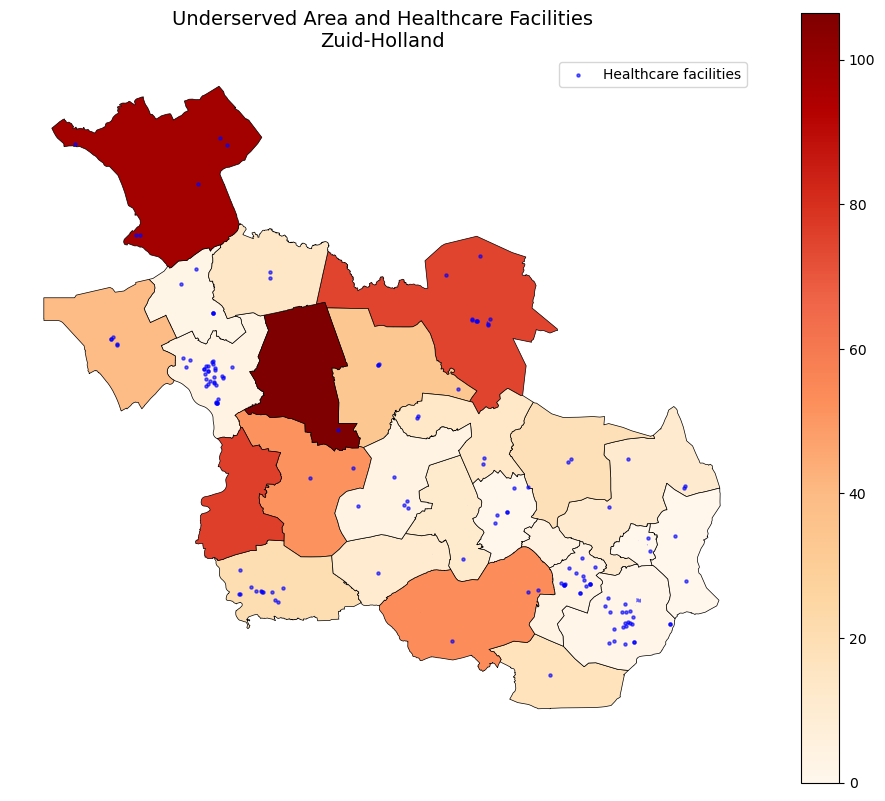

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

result.plot(
    column="underserved_area_km2",
    cmap="OrRd",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.5
)

healthcare_zuid_holland.plot(
    ax=ax,
    color="blue",
    markersize=5,
    alpha=0.6,
    label="Healthcare facilities"
)

ax.set_title("Underserved Area and Healthcare Facilities\nZuid-Holland", fontsize=14)
ax.set_axis_off()
ax.legend()

plt.show()


In [80]:
# ------------------------- #
# 3. Calculate underserved ratio per municipality
# ------------------------- #

# Compute total municipality area
result["total_area_m2"] = result.geometry.area

# Compute underserved ratio = underserved area / total area
result["underserved_ratio"] = result["underserved_area_m2"] / result["total_area_m2"]

# Clean invalid values
result["underserved_ratio"] = result["underserved_ratio"].replace([np.inf, -np.inf], np.nan).fillna(0)

# ------------------------- #
# Sort and print Top 5
# ------------------------- #
print("\nQ 3. Calculate the ratio of underserved area to total municipality area.")
top5_ratio = result.sort_values("underserved_ratio", ascending=False).head(5)

print("\nTop 5 municipalities by underserved area ratio:")
for _, row in top5_ratio.iterrows():
    print(f"- {row['naam']}: {row['underserved_ratio']:.3f}")



Q 3. Calculate the ratio of underserved area to total municipality area.

Top 5 municipalities by underserved area ratio:
- Olst-Wijhe: 0.641
- Dalfsen: 0.640
- Steenwijkerland: 0.302
- Raalte: 0.298
- Hof van Twente: 0.247


In [81]:
# -------------------------
#4. Report the municipalities with the lowest and highest underserved area.
# Municipality with lowest underserved area
# -------------------------
lowest = result.loc[result["underserved_area_m2"].idxmin()]

# -------------------------
# Municipality with highest underserved area
# -------------------------
print("\nQ 4. Report the municipalities with the lowest and highest underserved area.")
highest = result.loc[result["underserved_area_m2"].idxmax()]

print("\nMunicipality with LOWEST underserved area:")
print(f" - {lowest['naam']}: {lowest['underserved_area_m2'] / 1e6:.2f} km²")

print("\nMunicipality with HIGHEST underserved area:")
print(f" - {highest['naam']}: {highest['underserved_area_m2'] / 1e6:.2f} km²")



Q 4. Report the municipalities with the lowest and highest underserved area.

Municipality with LOWEST underserved area:
 - Losser: 0.00 km²

Municipality with HIGHEST underserved area:
 - Dalfsen: 106.52 km²


In [82]:
# ------------------------- #
# 5. Identify municipalities with high population density but low healthcare facility density
# (robust, safe to re-run)
# ------------------------- #
pop["PD_NL_LAU_T_OBS_VALUE"] = pd.to_numeric(pop["PD_NL_LAU_T_OBS_VALUE"], errors="coerce")
pop["landAreaValue"] = pd.to_numeric(pop["landAreaValue"], errors="coerce")

print("Starting robust high-risk municipality analysis...")

# -------------------------
# Safety checks
# -------------------------
required = ["province_munis", "healthcare_zuid_holland", "pop"]
for r in required:
    if r not in globals():
        raise NameError(f"Missing required object: {r}")

province_munis = province_munis.to_crs(epsg=28992)
healthcare_zuid_holland = healthcare_zuid_holland.to_crs(epsg=28992)
pop = pop.to_crs(epsg=28992)

# -------------------------
# Auto-detect population & area columns
# -------------------------
pop_col = next((c for c in pop.columns if "obs" in c.lower()), None)
area_col = next((c for c in pop.columns if "area" in c.lower()), None)

if pop_col is None or area_col is None:
    raise ValueError("Could not detect population or area column automatically.")

print(f"Using population column: {pop_col}")
print(f"Using area column: {area_col}")

# -------------------------
# Clean population table
# -------------------------
pop[pop_col] = pd.to_numeric(pop[pop_col], errors="coerce")
pop[area_col] = pd.to_numeric(pop[area_col], errors="coerce")

pop = pop.dropna(subset=[pop_col, area_col])
pop = pop[pop[area_col] > 0]

if pop.empty:
    raise ValueError("Population table empty after cleaning.")

# -------------------------
# Spatial join population → municipalities
# -------------------------
pop_muni = gpd.sjoin(
    pop,
    province_munis[["naam", "geometry"]],
    how="inner",
    predicate="intersects"
)

print(f"Population polygons assigned to municipalities: {len(pop_muni)}")

# -------------------------
# Compute population density per municipality
# -------------------------
pop_density = (
    pop_muni.groupby("naam")[[pop_col, area_col]]
    .sum()
    .reset_index()
)

pop_density["pop_density"] = pop_density[pop_col] / pop_density[area_col]

# -------------------------
# Build result base table
# -------------------------
result = province_munis.copy()

# Merge pop density
result = result.merge(pop_density[["naam", "pop_density"]], on="naam", how="left")
result["pop_density"] = result["pop_density"].replace([np.inf, -np.inf], np.nan)

# -------------------------
# Healthcare density
# -------------------------
hc_muni = gpd.sjoin(
    healthcare_zuid_holland,
    province_munis[["naam", "geometry"]],
    how="inner",
    predicate="within"
)

hc_count = hc_muni.groupby("naam").size().reset_index(name="facility_count")

result = result.merge(hc_count, on="naam", how="left")
result["facility_count"] = result["facility_count"].fillna(0)

result["area_km2"] = result.geometry.area / 1e6
result["facility_density"] = result["facility_count"] / result["area_km2"]
result["facility_density"] = result["facility_density"].replace([np.inf, -np.inf], np.nan)

# -------------------------
# Thresholds
# -------------------------
if result["pop_density"].dropna().empty:
    raise ValueError("No valid population density values found.")

pop_thresh = result["pop_density"].dropna().quantile(0.75)
facility_thresh = result["facility_density"].dropna().quantile(0.25)

# -------------------------
# High-risk classification
# -------------------------
result["high_risk"] = (
    (result["pop_density"] >= pop_thresh) &
    (result["facility_density"] <= facility_thresh)
)

high_risk = result[result["high_risk"]]

# -------------------------
# Output
# -------------------------
print("\nQ 5. Identify municipalities healthcare facility imbalance, i.e., high population density but low healthcare facility density.")
print(f"\nPopulation density threshold (75th percentile): {pop_thresh:.4f}")
print(f"Facility density threshold (25th percentile): {facility_thresh:.4f}")

print("\nHigh-risk municipalities (high demand, low supply):")
if high_risk.empty:
    print("None identified.")
else:
    for _, r in high_risk.iterrows():
        print(f"- {r['naam']}: PopDensity={r['pop_density']:.4f}, FacilityDensity={r['facility_density']:.4f}")

print("\nAnalysis complete.")


Starting robust high-risk municipality analysis...
Using population column: PD_NL_LAU_T_OBS_VALUE
Using area column: areaValue
Population polygons assigned to municipalities: 161

Q 5. Identify municipalities healthcare facility imbalance, i.e., high population density but low healthcare facility density.

Population density threshold (75th percentile): 0.0004
Facility density threshold (25th percentile): 0.0186

High-risk municipalities (high demand, low supply):
- Haaksbergen: PopDensity=0.0004, FacilityDensity=0.0095
- Olst-Wijhe: PopDensity=0.0004, FacilityDensity=0.0000

Analysis complete.


In [85]:
# -------------------------
# map visualization
# -------------------------
# -------------------------
# Safety checks
# -------------------------
required = ["result", "healthcare_zuid_holland"]
for name in required:
    if name not in globals():
        raise NameError(f"Required object '{name}' not found. Run previous steps first.")

# -------------------------
# Convert to WGS84 for folium
# -------------------------
result_wgs = result.to_crs(epsg=4326)
hc_wgs = healthcare_zuid_holland.to_crs(epsg=4326)

# -------------------------
# Get map center
# -------------------------
center = result_wgs.geometry.union_all().centroid
center_latlon = [center.y, center.x]

# -------------------------
# Create base map
# -------------------------
m = folium.Map(
    location=center_latlon,
    zoom_start=9,
    tiles="OpenStreetMap"
)

# -------------------------
# Add municipalities
# -------------------------
for _, row in result_wgs.iterrows():
    color = "red" if row.get("high_risk", False) else "#cccccc"

    folium.GeoJson(
        row.geometry,
        style_function=lambda x, col=color: {
            "fillColor": col,
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.6 if col == "red" else 0.3
        },
        tooltip=f"{row['naam']}<br>Pop density: {row.get('pop_density', 'NA'):.4f}<br>Facility density: {row.get('facility_density', 'NA'):.4f}"
    ).add_to(m)

# -------------------------
# Add healthcare facilities safely
# -------------------------
for _, row in hc_wgs.iterrows():
    geom = row.geometry

    # Convert polygon → centroid if needed
    if geom.geom_type == "Point":
        latlon = [geom.y, geom.x]
    else:
        c = geom.centroid
        latlon = [c.y, c.x]

    folium.CircleMarker(
        location=latlon,
        radius=3,
        color="blue",
        fill=True,
        fill_opacity=0.7,
        popup=row.get("name", "Healthcare facility")
    ).add_to(m)

# -------------------------
# Add legend (HTML)
# -------------------------
legend_html = """
<div style="
position: fixed;
bottom: 50px;
left: 50px;
width: 220px;
height: 120px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding:10px;">
<b>Legend</b><br>
<span style="background-color:red;width:12px;height:12px;display:inline-block;"></span> High-risk municipality<br>
<span style="background-color:#cccccc;width:12px;height:12px;display:inline-block;"></span> Other municipality<br>
<span style="color:blue;">●</span> Healthcare facility
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# -------------------------
# Save and display
# -------------------------
map_file = Path("high_risk_healthcare_map.html")
m.save(map_file)

print(f"Map saved to: {map_file.resolve()}")
map_file



# Save map
map_file = Path("high_risk_healthcare_map.html")
m.save(map_file)

# # Display inline inside Jupyter
# display(IFrame(src=str(map_file), width="100%", height="600"))

# Open in default browser (Windows)
webbrowser.open(map_file.resolve().as_uri())

Map saved to: C:\Users\kkham\high_risk_healthcare_map.html


True

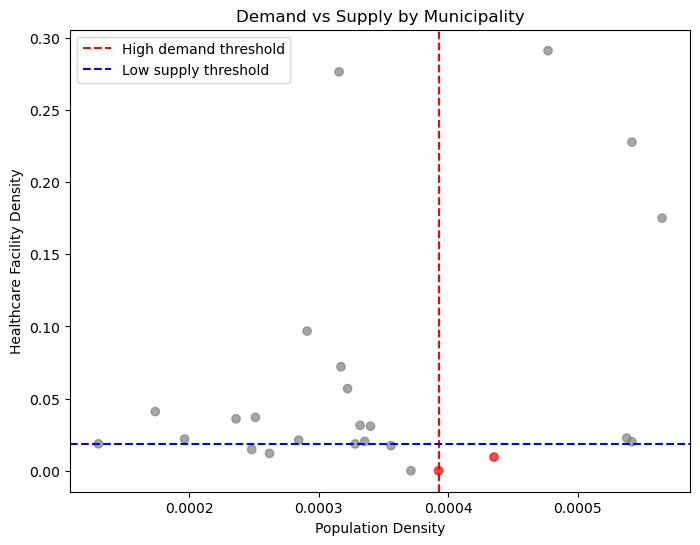

In [84]:
# -------------------------
# Scatter plot visualization
# -------------------------
plt.figure(figsize=(8, 6))

plt.scatter(
    result["pop_density"],
    result["facility_density"],
    c=result["high_risk"].map({True: "red", False: "grey"}),
    alpha=0.7
)

plt.axvline(pop_thresh, color="red", linestyle="--", label="High demand threshold")
plt.axhline(facility_thresh, color="blue", linestyle="--", label="Low supply threshold")

plt.xlabel("Population Density")
plt.ylabel("Healthcare Facility Density")
plt.title("Demand vs Supply by Municipality")
plt.legend()
plt.show()
